# Steps I am following


1. Parse the TSP file to extract the city coordinates.
2. Normalize the coordinates to the range [0, 1].
3. Define the architecture of the autoencoder.
4. Compile the autoencoder.
5. Train the autoencoder on the normalized coordinates.
6. Use the encoder part of the autoencoder to reduce the dimensionality of the coordinates.

# Importing the required libraries

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import mean_squared_error

# Extracting the city coordinates from the TSP file

In [2]:
directory = "instances\\instances"
tsp_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.tsp')]

all_data = []

for tsp_file in tqdm(tsp_files, desc="Processing files"):
    with open(tsp_file, 'r') as file:
        line = next(file)
        while "NODE_COORD_SECTION" not in line:
            line = next(file)
        data = file.readlines()
        data = data[:-1]
        data = np.array([[float(x) for x in line.split()[1:]] for line in data])
        all_data.append(data)

Processing files: 100%|██████████| 85/85 [00:00<00:00, 5014.85it/s]


In [3]:
all_data

[array([[6075.80690883, 6465.45909703],
        [1805.70936324, 7995.40708724],
        [5445.28520579, 4709.20131029],
        [4958.44692288, 4673.99712767],
        [2533.03662596, 3778.68980327],
        [5038.68622672, 9796.68082874],
        [6903.3503692 , 4121.00671839],
        [7731.86159653, 8600.15855725],
        [6109.27394038, 4844.82230302],
        [5669.76696326, 6325.04570949],
        [4203.46698965, 9567.63730817],
        [9513.85872349, 7458.0256731 ],
        [8418.09143448, 2834.239121  ],
        [3805.69633892,  701.2654226 ],
        [3408.63315541, 4874.74892224],
        [3582.42753262, 6734.82379683],
        [7579.38368103, 8807.63612896],
        [4465.23067265, 4254.65677598],
        [3426.01275677, 6253.61220366],
        [6655.96131254, 5903.31317429],
        [6321.24269797, 5975.00697937],
        [6949.93866269, 5136.07976256],
        [3670.93053929, 5273.2679205 ],
        [8398.71945481, 1526.18903204],
        [8242.73103951, 2731.55327006],


# Graphing the city coordinates

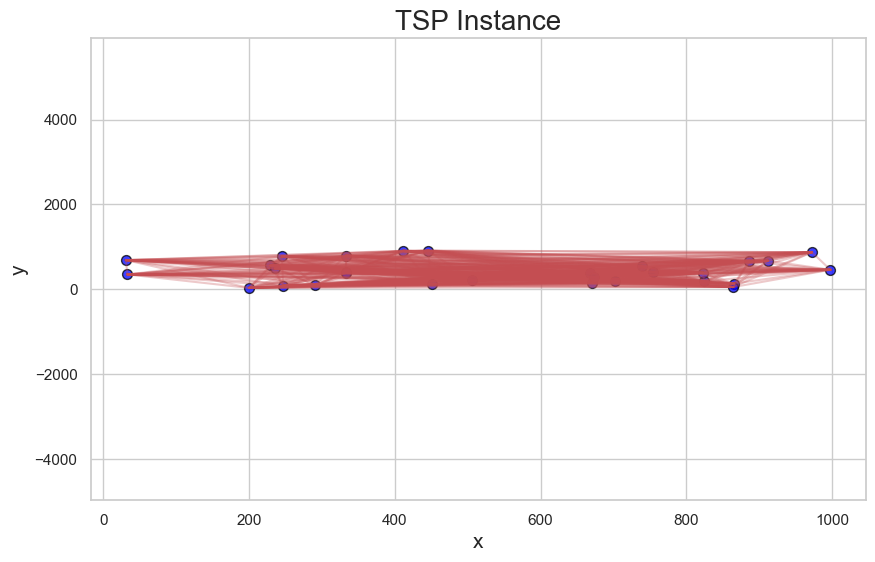

In [4]:
sns.set(style="whitegrid")
data = random.choice(all_data)
x, y = data[:, 0], data[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=50, c='blue', edgecolors='black', linewidth=1, alpha=0.75)

for j in range(len(x)):
    for k in range(j+1, len(x)):
        plt.plot([x[j], x[k]], [y[j], y[k]], 'r-', alpha=0.3)

plt.ylim(min(y) - 5000, max(y) + 5000)

plt.title('TSP Instance', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)

plt.show()

# Normalizing the coordinates

In [5]:
scaler = MinMaxScaler()
normalized_data = []

for data in all_data:
    normalized_data.append(scaler.fit_transform(data))

In [6]:
normalized_data

[array([[0.55397182, 0.63374716],
        [0.        , 0.80195806],
        [0.47217246, 0.44065452],
        [0.40901355, 0.43678398],
        [0.09435822, 0.33834896],
        [0.41942323, 1.        ],
        [0.66133137, 0.37598517],
        [0.76881648, 0.86844776],
        [0.55831359, 0.45556544],
        [0.50129511, 0.61830934],
        [0.31106787, 0.9748177 ],
        [1.        , 0.74287539],
        [0.85784301, 0.23451086],
        [0.25946396, 0.        ],
        [0.20795183, 0.45885573],
        [0.23049867, 0.6633626 ],
        [0.74903509, 0.89125899],
        [0.34502722, 0.39067939],
        [0.21020654, 0.61045555],
        [0.62923689, 0.57194174],
        [0.5858129 , 0.57982416],
        [0.6673754 , 0.48758788],
        [0.24198041, 0.5026711 ],
        [0.85532983, 0.09069664],
        [0.83509301, 0.22322101],
        [0.52278943, 0.67716175],
        [0.58651642, 0.40206787],
        [0.86096475, 0.01355847],
        [0.41617046, 0.32043499]]),
 array([[0.3

# Defining the architecture of the autoencoder

In [7]:
from keras import regularizers

encoding_dim = 32

input_data = Input(shape=(29,2))

encoded = Dense(64, activation='relu')(input_data) # To-Do: Reduce the dimensionality
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)

decoded = Dense(64, activation='relu')(encoded) # To-Do: Reduce the dimensionality
decoded = Dense(2, activation='sigmoid')(decoded)

autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[-2]
decoder_layer2 = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer2(decoder_layer1(encoded_input)))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29, 2)]           0         
                                                                 
 dense (Dense)               (None, 29, 64)            192       
                                                                 
 dense_1 (Dense)             (None, 29, 32)            2080      
                                                                 
 dense_2 (Dense)             multiple                  2112      
                                                                 
 dense_3 (Dense)             multiple                  130       
                                                                 
Total params: 4514 (17.63 KB)
Trainable params: 4514 (17.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
normalized_data = np.stack(normalized_data, axis=0)
checkpoint = ModelCheckpoint('best_model_TSP.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = autoencoder.fit(normalized_data, normalized_data, epochs=2000, validation_split=0.2, verbose=0, callbacks=[checkpoint])


Epoch 1: val_loss improved from inf to 0.09141, saving model to best_model_TSP.h5

Epoch 2: val_loss improved from 0.09141 to 0.08826, saving model to best_model_TSP.h5

Epoch 3: val_loss improved from 0.08826 to 0.08539, saving model to best_model_TSP.h5

Epoch 4: val_loss improved from 0.08539 to 0.08274, saving model to best_model_TSP.h5


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 5: val_loss improved from 0.08274 to 0.08004, saving model to best_model_TSP.h5

Epoch 6: val_loss improved from 0.08004 to 0.07725, saving model to best_model_TSP.h5

Epoch 7: val_loss improved from 0.07725 to 0.07431, saving model to best_model_TSP.h5

Epoch 8: val_loss improved from 0.07431 to 0.07107, saving model to best_model_TSP.h5

Epoch 9: val_loss improved from 0.07107 to 0.06752, saving model to best_model_TSP.h5

Epoch 10: val_loss improved from 0.06752 to 0.06379, saving model to best_model_TSP.h5

Epoch 11: val_loss improved from 0.06379 to 0.06000, saving model to best_model_TSP.h5

Epoch 12: val_loss improved from 0.06000 to 0.05637, saving model to best_model_TSP.h5

Epoch 13: val_loss improved from 0.05637 to 0.05287, saving model to best_model_TSP.h5

Epoch 14: val_loss improved from 0.05287 to 0.04945, saving model to best_model_TSP.h5

Epoch 15: val_loss improved from 0.04945 to 0.04622, saving model to best_model_TSP.h5

Epoch 16: val_loss improved from 0.0

## Plotting the loss

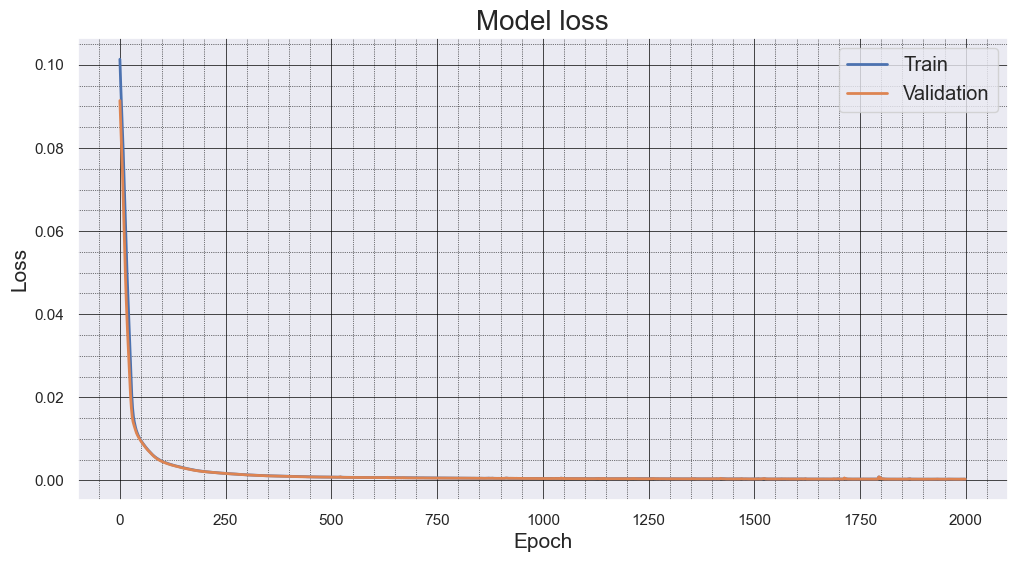

In [9]:
sns.set_theme()

plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'], linewidth=2)
plt.plot(history.history['val_loss'], linewidth=2)

plt.title('Model loss', fontsize=20)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.grid(True)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize='large')

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.show()

### Plotting Best vs Original model

1/1 [==============================] - 0s 29ms/step - loss: 2.9721e-04


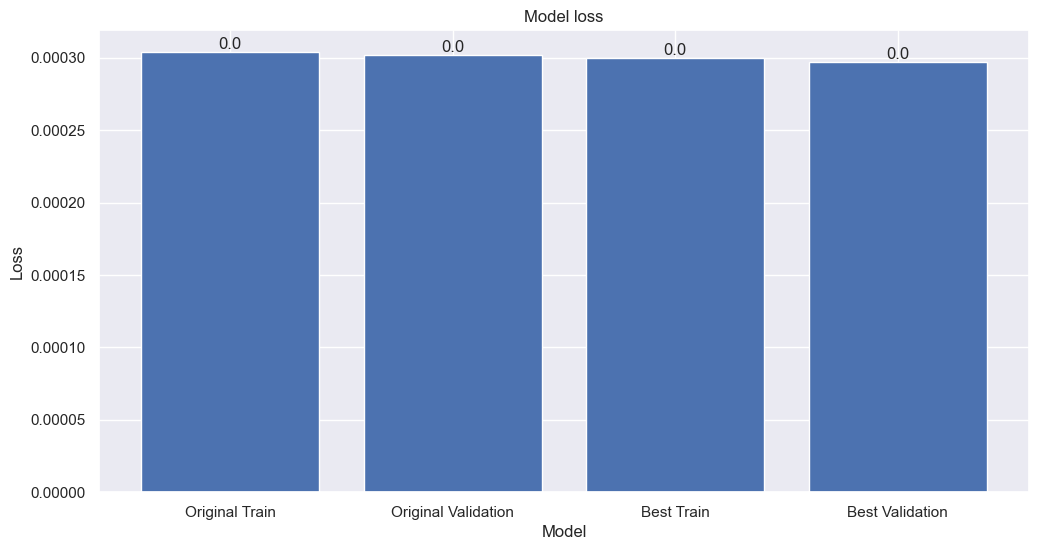

In [10]:
best_model = load_model('best_model_TSP.h5')
train_data, val_data = train_test_split(normalized_data, test_size=0.2)

original_train_loss = autoencoder.evaluate(train_data, train_data)
original_val_loss = autoencoder.evaluate(val_data, val_data)
best_train_loss = best_model.evaluate(train_data, train_data)
best_val_loss = best_model.evaluate(val_data, val_data)

plt.figure(figsize=(12, 6))
bars = plt.bar(['Original Train', 'Original Validation', 'Best Train', 'Best Validation'], 
        [original_train_loss, original_val_loss, best_train_loss, best_val_loss])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Model')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

### Loss of the Model

In [11]:
saved_model = load_model('best_model_TSP.h5')
loss = saved_model.evaluate(normalized_data, normalized_data)
print('Loss:', loss)

3/3 [==============================] - 0s 3ms/step - loss: 2.9954e-04
Loss: 0.00029953656485304236


### Comparing the original data to the reconstructed data

In [12]:
data_reconstructed = saved_model.predict(normalized_data)

print('Original data:', normalized_data[0])

3/3 [==============================] - 0s 3ms/step
Original data: [[0.55397182 0.63374716]
 [0.         0.80195806]
 [0.47217246 0.44065452]
 [0.40901355 0.43678398]
 [0.09435822 0.33834896]
 [0.41942323 1.        ]
 [0.66133137 0.37598517]
 [0.76881648 0.86844776]
 [0.55831359 0.45556544]
 [0.50129511 0.61830934]
 [0.31106787 0.9748177 ]
 [1.         0.74287539]
 [0.85784301 0.23451086]
 [0.25946396 0.        ]
 [0.20795183 0.45885573]
 [0.23049867 0.6633626 ]
 [0.74903509 0.89125899]
 [0.34502722 0.39067939]
 [0.21020654 0.61045555]
 [0.62923689 0.57194174]
 [0.5858129  0.57982416]
 [0.6673754  0.48758788]
 [0.24198041 0.5026711 ]
 [0.85532983 0.09069664]
 [0.83509301 0.22322101]
 [0.52278943 0.67716175]
 [0.58651642 0.40206787]
 [0.86096475 0.01355847]
 [0.41617046 0.32043499]]


In [13]:
print('Reconstructed data:', data_reconstructed[0])

Reconstructed data: [[0.5557906  0.6321894 ]
 [0.01111012 0.7998732 ]
 [0.47474426 0.44957998]
 [0.40816447 0.4469792 ]
 [0.09453274 0.34006122]
 [0.41823173 0.9884445 ]
 [0.6685984  0.37572485]
 [0.77054495 0.87235713]
 [0.5619227  0.46639287]
 [0.49954662 0.6167492 ]
 [0.3109915  0.97663355]
 [0.9858918  0.73914844]
 [0.85302323 0.238862  ]
 [0.26401797 0.00815926]
 [0.22140504 0.45608917]
 [0.24031402 0.6685249 ]
 [0.74839556 0.8923113 ]
 [0.34174672 0.39226255]
 [0.2226713  0.61253536]
 [0.6260894  0.574121  ]
 [0.58866245 0.5808197 ]
 [0.66974753 0.48294953]
 [0.24915428 0.50684077]
 [0.8520978  0.09163537]
 [0.8349136  0.23018098]
 [0.52386117 0.67721105]
 [0.5842822  0.40585336]
 [0.8548124  0.01785132]
 [0.41336122 0.31677893]]


In [14]:
input_shape = saved_model.layers[0].input_shape
print('Model input shape:', input_shape)

Model input shape: [(None, 29, 2)]


# Mean Squared Error of the Model

In [15]:
normalized_data_reshaped = normalized_data.reshape(-1, 29, 2)

reconstructed_data = autoencoder.predict(normalized_data_reshaped)

reconstructed_data_reshaped = reconstructed_data.reshape(reconstructed_data.shape[0], -1)
normalized_data_flattened = normalized_data_reshaped.reshape(normalized_data_reshaped.shape[0], -1)

mse = mean_squared_error(normalized_data_flattened, reconstructed_data_reshaped)

print('Mean Squared Error:', mse)

3/3 [==============================] - 0s 3ms/step
Mean Squared Error: 3.412334776994699e-05
